In [10]:
from typing import List, Dict, Tuple,Callable
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt
import load_workload_data as ld
import load_benchmark_data as bn


sns.set(rc={'figure.figsize':(7.5,10)})

In [11]:
benchmark = "TPC-H"
single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
multi_threaded_folder: Path = Path(f"../data/koroneia_{benchmark}_sf10_multithreaded/")
sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder, "Dictionary")
low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder, "Dictionary")
low_level_single: DataFrame = bn.get_low_level(single_threaded_folder)
high_level_mult

KeyError: 'Size (in Bytes)'

In [7]:
only_28_clients_mult = high_level_mult[high_level_mult[bn.CLIENTS] != 14]
only_28_clients_single = high_level_single[high_level_single[bn.CLIENTS] != 14]
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE, bn.CLIENTS]
only_28_clients_mult[columns_to_merge].sort_values(by=[bn.LIBRARY_NAME, bn.CLIENTS])

,Library Name,Runtime Library / Runtime Baseline,size_to_baseline,Clients
0,CompactVector,0.909454,0.477447,24
7,CompactVector,0.904431,0.477447,48
1,Dictionary,1.000000,1.000000,24
8,Dictionary,1.000000,1.000000,48
2,FrameOfReference,0.920374,0.722096,24
9,FrameOfReference,0.919889,0.722096,48
3,SIMDCAI,0.936198,0.470938,24
10,SIMDCAI,0.941869,0.470938,48
4,TurboPFOR,0.954957,0.474542,24
11,TurboPFOR,0.976593,0.474542,48


## Runtime


In [197]:
def benchmark_name(benchmark: str) -> str:
    map: Dict[str, str] = {
        "TPC-H" : "TPC-H",
        "TPC-DS" : "TPC-DS",
        "JOB" : "Join Order Benchmark"
    }
    return map[benchmark]

def load_all_benchmakrs_high_multi(benchmark: str, sf: int, arch: str, baseline: str) -> DataFrame:
    sizes_folder: Path = Path(f"../data/{arch}_{benchmark}_sf{sf}_singlethreaded/")
    multi_threaded_folder: Path = Path(f"../data/{arch}_{benchmark}_sf{sf}_multithreaded/")
    df = bn.get_high_level(multi_threaded_folder, sizes_folder, baseline)
    df["Benchmark"] = [benchmark_name(benchmark) for i in range(0, len(df))]
    return df[df[bn.CLIENTS] == 28]

def load_all_benchmakrs_high_single(benchmark: str, sf: int, arch: str, baseline: str) -> DataFrame:
    sizes_folder: Path = Path(f"../data/{arch}_{benchmark}_sf{sf}_singlethreaded/")
    single_threaded_folder: Path = Path(f"../data/{arch}_{benchmark}_sf{sf}_singlethreaded/")
    df = bn.get_high_level(single_threaded_folder, sizes_folder, baseline)
    df["Benchmark"] = [benchmark_name(benchmark) for i in range(0, len(df))]
    return df

def colors() -> Dict[str,str]:
    return {
        "bitpacking_compactvector" : "C2",
        "bitpacking_turboPFOR" : "C2",
        "for_Hyrise" : "C1",
        "for_SIMDCAI_simd" : "C1",
        "pfor_turboPFOR" : "C1",
        "unencoded_Hyrise" : "C4",
        "dictionary_Hyrise" : "C0",
        "simdbp128_Hyrise": "C3",
        "bytepacking_Hyrise_fsba": "C0",
        "bitpacking_compactvector_16": "C2"
    }

def markers(baseline: str) -> Dict[str, str]:
    markers_dict = {
        "bitpacking_compactvector" : "o",
        "bitpacking_turboPFOR" : "d",
        "for_Hyrise" : "^",
        "for_SIMDCAI_simd" : "d",
        "pfor_turboPFOR" : "o",
        "unencoded_Hyrise" : "o",
        "dictionary_Hyrise" : "s",
        "bytepacking_Hyrise_fsba": "o",
        "bitpacking_compactvector_16": "^"
    }
    markers_dict[bn.fancy_name(baseline)] = "s"
    return markers_dict

def pareto_frontier(Xs, Ys, maxX=False, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    return pareto_front

def connect_dominated_points(ax, data: DataFrame, x: str, y: str):
    x_values = list(data[x])
    y_values = list(data[y])
    par: List[Tuple[int, int]] = pareto_frontier(x_values, y_values)
    #print(par)
    par.append([max(x_values), par[-1][1]])
    ax.plot([p[0] for p in par], [p[1] for p in par], color="grey", linestyle="dashed", alpha=0.4)

def plot_single(arch: str, filename: str, baseline: str, columns: int=4):
    all_benchmarks_single: DataFrame = load_all_benchmakrs_high_single("TPC-H", 10, arch, baseline)\
                                .append(load_all_benchmakrs_high_single("TPC-DS", 10, arch, baseline))\
                                .append(load_all_benchmakrs_high_single("JOB", 10, arch, baseline))
    all_benchmarks_single = all_benchmarks_single.sort_values([bn.PAPER_NAME], kind="mergesort")
    g = sns.FacetGrid(all_benchmarks_single, col="Benchmark", height=2, aspect=1.6)
    g.map_dataframe(sns.scatterplot, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE, hue=bn.PAPER_NAME, style=bn.PAPER_NAME, markers=markers(baseline), palette=colors(), s=50)
    g.set_axis_labels("", "Relative Runtime\n(Single-threaded)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    plt.legend(bbox_to_anchor=(-2.1,1, 3,0.8), loc=2, mode="expand", ncol=columns)

    for ax in g.axes.flatten():
        benchmark = ax.title.get_text()
        data_for_benchmark = all_benchmarks_single[all_benchmarks_single["Benchmark"] == benchmark]
        connect_dominated_points(ax, data=data_for_benchmark, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE)
    plt.savefig(f"visualizations/{filename}", bbox_inches="tight", format="svg")

def plot_multi(arch: str, filename: str, baseline: str, x_label: str):
    all_benchmarks: DataFrame = load_all_benchmakrs_high_multi("TPC-H", 10, arch, baseline)\
                                    .append(load_all_benchmakrs_high_multi("TPC-DS", 10, arch, baseline))\
                                    .append(load_all_benchmakrs_high_multi("JOB", 10, arch, baseline))
    all_benchmarks = all_benchmarks.sort_values([bn.PAPER_NAME], kind="mergesort")
    g = sns.FacetGrid(all_benchmarks, col="Benchmark", height=2, aspect=1.6)
    g.map_dataframe(sns.scatterplot, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE, style=bn.PAPER_NAME, hue=bn.PAPER_NAME, markers=markers(baseline), palette=colors(), s=50)
    g.set_axis_labels(x_label, "Relative Runtime\n(28 Clients)")
    g.set_titles(col_template="{col_name}")

    for ax in g.axes.flatten():
        benchmark = ax.title.get_text()
        data_for_benchmark = all_benchmarks[all_benchmarks["Benchmark"] == benchmark]
        connect_dominated_points(ax, data=data_for_benchmark, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE)
    g.set_titles(col_template="")
    plt.savefig(f"visualizations/{filename}", bbox_inches="tight")

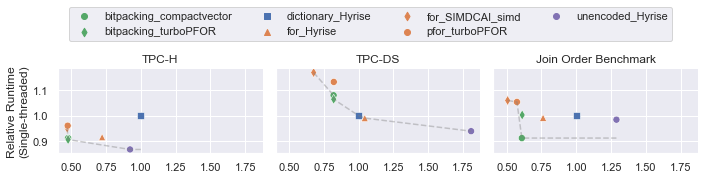

In [198]:
plot_single("nemea", "pareto_segment_single.svg", "Dictionary")

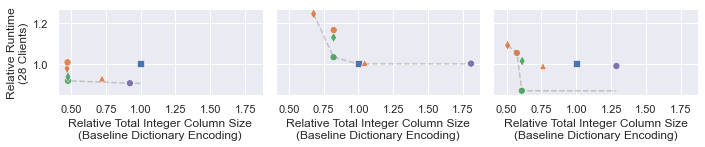

In [199]:
plot_multi("nemea", "pareto_segment_multi.svg", "Dictionary", "Relative Total Integer Column Size\n(Baseline Dictionary Encoding)")

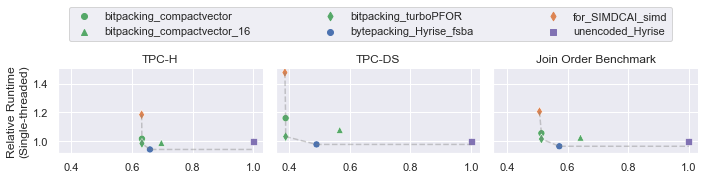

In [200]:
plot_single("nemeaCol", "pareto_column_single.svg", "compressionUnencoded", columns=3)

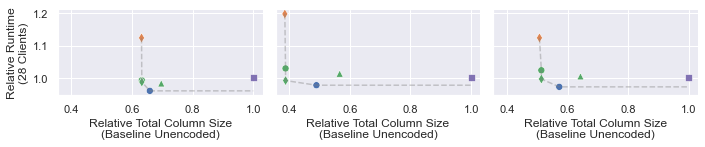

In [201]:
plot_multi("nemeaCol", "pareto_column_multi.svg", "compressionUnencoded", "Relative Total Column Size\n(Baseline Unencoded)")

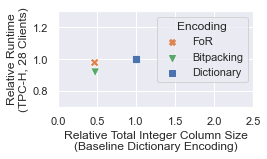

In [79]:
# Teaser Plot

def sort_df(data: DataFrame, function: Callable) -> DataFrame:
    copied = data.copy()
    copied["Sort"] = [function(row) for i, row in copied.iterrows()]
    copied = copied.sort_values(["Sort"])
    return copied.drop("Sort", axis=1)

def colors_teaser() -> Dict[str,str]:
    return {
        "Bitpacking" : "C2",
        "FoR" : "C1",
        "Dictionary": "C0"
    }

def markers_teaser() -> Dict[str, str]:
    return {
        "Bitpacking" : "v",
        "FoR" : "X",
        "Dictionary" : "s",
    }

sns.set(rc={'figure.figsize':(3.5,1.75)})
data: DataFrame = load_all_benchmakrs_high_multi("TPC-H", 10, "nemea", "Dictionary")
data = data[data[bn.LIBRARY_NAME].isin(["Dictionary", "CompactVector", "SIMDCAI"])]
NAME = "Encoding"
data[NAME] = [{"Dictionary": "Dictionary", "CompactVector" : "Bitpacking", "SIMDCAI": "FoR"}[lib]
              for lib in data[bn.LIBRARY_NAME]]
data = sort_df(data, lambda row: {"Dictionary": 3, "Bitpacking" : 1, "FoR": 0}[row[NAME]])
sns.scatterplot(data=data, x=bn.SIZE_TO_BASELINE, y=bn.RUNTIME_TO_BASELINE, hue=NAME, style=NAME, palette=colors_teaser(), markers=markers_teaser(), s=75)
plt.ylabel("Relative Runtime\n(TPC-H, 28 Clients)")
plt.xlabel("Relative Total Integer Column Size\n(Baseline Dictionary Encoding)")
plt.ylim(0.7,1.3)
plt.xlim(0,2.5)
plt.savefig("visualizations/Teaser.svg", bbox_inches="tight")

In [80]:
BIN = "Distinct Values in Segment"
DISTINCT = "distinct_value_count"
RELATIVE_SIZE = "% of all Segments"

def round_down(num: int, divisor: int) -> int:
    return num - (num%divisor)

def round_up(num: int, divisor: int) -> int:
    return num - (num%divisor) + divisor

def load_segment_sizes(benchmark: str, libraries: List[str]) -> DataFrame:
    final_result: DataFrame = DataFrame()
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
    dictionary[bn.LIBRARY_NAME] = ["Dictionary" for i in range(0,len(dictionary))]
    dictionary[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in dictionary[bn.LIBRARY_NAME]]
    for library in libraries:
        integer_compressed: DataFrame = bn.load_sizes(sizes_folder / f"sizes_{library}.txt")
        integer_compressed[bn.LIBRARY_NAME] = [library for i in range(0,len(integer_compressed))]
        integer_compressed[bn.PAPER_NAME] = [bn.fancy_name(lib) for lib in integer_compressed[bn.LIBRARY_NAME]]
        columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES, bn.LIBRARY_NAME, bn.PAPER_NAME]
        merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],suffixes=("","_baseline"))
        merged[bn.SIZE_TO_BASELINE] = [x / y
                                     for x, y in zip(merged[bn.SIZE_IN_BYTES],
                                                     merged[f"{bn.SIZE_IN_BYTES}_baseline"])]
        int_columns = merged[merged[bn.DATA_TYPE] == "int"]
        final_result = final_result.append(int_columns)
    final_result["Benchmark"] = [benchmark for i in range(0,len(final_result))]
    return final_result

In [81]:
libraries: List[str] = list(high_level_mult[bn.LIBRARY_NAME].drop_duplicates())
libraries.remove("Dictionary")
sizes = load_segment_sizes("TPC-H",["Dictionary"]).append(load_segment_sizes("TPC-DS",["Dictionary"])).append(load_segment_sizes("JOB",["Dictionary"]))
sizes[BIN] = [f"{round_down(distinct, 25000)}-\n{min(round_up(distinct, 25000),65000)}"
              for distinct in sizes[DISTINCT]]
total_count: DataFrame = sizes.groupby(["Benchmark"], as_index=False).size()
count_per_bin: DataFrame = sizes.groupby(["Benchmark", BIN], as_index=False).size()
plot_data = count_per_bin.merge(total_count, on=["Benchmark"], suffixes=("", "_total"))
plot_data[RELATIVE_SIZE] = [size / size_total for size, size_total in zip(plot_data["size"], plot_data["size_total"])]
plot_data = plot_data.sort_values([BIN])
plot_data = plot_data.sort_values(["Benchmark"], ascending=False, kind="mergesort")

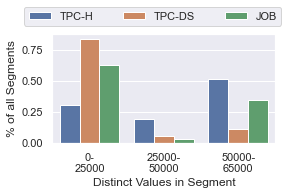

In [82]:
sns.set(rc={'figure.figsize':(4,2)})
sns.barplot(data=plot_data, x=BIN, y=RELATIVE_SIZE, hue="Benchmark")
plt.xlabel("Distinct Values in Segment")
plt.legend(bbox_to_anchor=(-0.15,-0.3,1.2,1.6), loc=2, mode="expand", ncol=4)
plt.savefig("visualizations/benchmarks_size_closer.svg", bbox_inches="tight")


## Cache

In [83]:
benchmark = "TPC-H"
sf10_folder = Path(f"../data/nemea_{benchmark}_sf10_perf")
sf30_folder: Path = Path(f"../data/nemea_{benchmark}_sf30_perf")
sf1_folder: Path = Path(f"../data/nemea_{benchmark}_sf1_perf")
high_level_sf10: DataFrame = bn.get_high_level(sf10_folder, sf10_folder)
high_level_sf30: DataFrame = bn.get_high_level(sf30_folder, sf30_folder)
high_level_sf1: DataFrame = bn.get_high_level(sf1_folder, sf1_folder)

In [84]:
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE]
high_level_sf10[columns_to_merge].merge(high_level_sf1[columns_to_merge], on=[bn.LIBRARY_NAME])

,Library Name,Runtime Library / Runtime Baseline _x,size_to_baseline_x,Runtime Library / Runtime Baseline _y,size_to_baseline_y
0,CompactVector,0.915542,0.576155,0.948230,0.660729
1,Dictionary,1.000000,1.000000,1.000000,1.000000
2,FrameOfReference,0.927696,0.722096,0.958508,0.781401
3,SIMDCAI,0.979859,0.470938,1.023928,0.515864
4,TurboPFOR,1.005736,0.474542,1.016647,0.517243
5,TurboPFOR_bitpacking,0.947954,0.477655,0.973697,0.520400
6,Unencoded,0.906204,0.922766,0.934015,1.169736


In [85]:
CACHE_EVENT: str = "cache_event"
VALUE: str = "Value"
INT_IN_GB: str = "Total Integer Size (in GB)"
REL_VALUE: str = "Event Count relative to Dictionary L2 Loads\n(using perf and Intel Performance Counters)"

def load_cache(path: Path) -> DataFrame:
    df: DataFrame = DataFrame()
    with path.open() as file:
        for line in file:
            if "<not supported>" in line:
                continue
            if not "l2" in line and not "LLC" in line:
                continue
            if "store" in line or "hit" in line:
                continue
            df[line.split()[1]] = [int(line.split()[0])]
    return df

def rename_name(cache_event: str) -> str:
    rename: Dict[str, str] = {
        "l2_rqsts.all_demand_data_rd:u" : "L2 Load",
        "l2_rqsts.demand_data_rd_miss:u" : "L2 Miss",
        "LLC-loads:u": "L3 Load",
        "LLC-load-misses:u": "L3 Miss"
    }
    return rename[cache_event]

def complete_with_cache_results(data: DataFrame, base_folder) -> DataFrame:
    all_results: DataFrame = DataFrame()
    scale_factor: int = data[bn.SCALE_FACTOR][0]
    for library in data[bn.LIBRARY_NAME]:
        cache_results: DataFrame = load_cache(base_folder / f"{library}_cache_sf{scale_factor}_multi.txt") \
                                   - load_cache(base_folder / f"{library}_baseline_sf{scale_factor}_multi.txt")
        cache_results[bn.LIBRARY_NAME] = library
        for column in list(cache_results):
            if column == bn.LIBRARY_NAME:
                continue
            base_throughput: int = list(data[data[bn.LIBRARY_NAME] == "Dictionary"]["avg_throughput"])[0]
            lib_throughput: int = list(data[data[bn.LIBRARY_NAME] == library]["avg_throughput"])[0]
            new_df: DataFrame = DataFrame({bn.LIBRARY_NAME: [library],
                                           CACHE_EVENT: column,
                                           VALUE: cache_results[column][0] * base_throughput / lib_throughput})
            all_results = all_results.append(new_df)
    merged = all_results.merge(data, on=[bn.LIBRARY_NAME])
    return merged

data = complete_with_cache_results(high_level_sf10, sf10_folder)
data[CACHE_EVENT] = [rename_name(event) for event in data[CACHE_EVENT]]
data["Order"] = [{"L3 Miss": 0, "L2 Miss": 1, "L3 Load" : 2, "L2 Load": 3}[event]
                 for event in data[CACHE_EVENT]]
data[INT_IN_GB] = [number / 1e9 for number in data["int"]]
data = data.sort_values([bn.PAPER_NAME, "Order"])
max_value = list(data[(data[CACHE_EVENT] == "L2 Load") & (data[bn.LIBRARY_NAME] == "Dictionary")][VALUE])[0]
data[REL_VALUE] = [value / max_value for value in data[VALUE]]

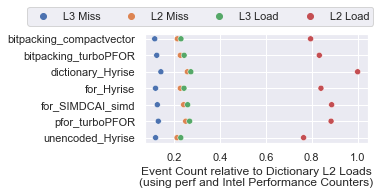

In [86]:
plt.figure(figsize=(4,2))
lineplot = sns.scatterplot(data=data, x=REL_VALUE, y=bn.PAPER_NAME, hue=CACHE_EVENT)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
lineplot.get_legend().set_title(None)
plt.legend(bbox_to_anchor=(-0.55,-0.3,1.6,1.6), loc=2, mode="expand", ncol=4)
plt.ylabel("")
plt.savefig("visualizations/Segment_Cache.svg", bbox_inches="tight")

In [87]:
plt.figure(figsize=(5,3))
lineplot = sns.lineplot(data=data, x=INT_IN_GB, y=, linestyle="--").set_ylim(0,2)
plt.xticks(rotation=90)
plt.savefig("visualizations/Segment_Cache_Size.svg", bbox_inches="tight")

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-87-731919a12417>, line 2)

In [ ]:
sizes

In [ ]:
sizes.groupby(["Benchmark"])[DISTINCT].mean()

In [ ]:
list(sizes)

